$$ \text{Projet  Image-Signal-Simulation} $$
===========
$$ \text{Recalage d'image $\ell^1$ - $\ell^2$} $$
======


$$ \text{Anne-Sophie Dusart & Guilhem Fouilhé & Chloé Michel & Damien Ricci} $$






In [ ]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
import warnings
import progressbar
from skimage.color import rgb2gray
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Fonctions nécéssaires pour minimiser notre énergie E(t)
===============

In [ ]:
def grad_x(img, adjoint=False):  
    '''
    adjoint = False : grad_x = Dx
    adjoint = True : grad_x = D*x
    '''
    sx, sy = np.shape(img)
    diff_x = np.copy(img)
    
    if not adjoint:
        for x in range(sx):
          if x==0:
                xprev=sx-1
          else:
                xprev=x-1
          for y in range(sy):
              diff_x[x,y] = img[x,y] - img[xprev,y]
  
    else:
        for x in range(sx):
          if x==sx-1:
              xnext=0
          else:
              xnext=x+1
          for y in range(sy):
              diff_x[x,y] = img[x,y] - img[xnext,y]

    return diff_x

###############################################

def grad_y(img, adjoint=False): 
    '''
    adjoint = False : grad_y = Dy
    adjoint = True : grad_y = D*y
    '''
    sx, sy = np.shape(img)
    diff_y =  np.copy(img)

    if not adjoint:
       
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,y] - img[x,yprev]
    else:
        for y in range(sy):

            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,y] - img[x,ynext]

    return diff_y

##################################################

'''grad_u = (grad_x, grad_y)'''
def grad_u(img, adjoint=False): 
  if not adjoint:
    return np.array([grad_x(img,adjoint),grad_y(img,adjoint)])

  else:  
    '''Si adjoint = True -> img = (v1,v2)'''
    v1,v2 = img
    return grad_x(v1,adjoint=True) + grad_y(v2,adjoint=True)

###################################################

def H(t, grad_v, adjoint=False):
  '''
  Ht = <grad_v^1(m,n),t(m,n)>
  
  adjoint = False : t must be size 2, returns scalar
  adjoint = True : t must be scalar, return size 2
  '''
  if not adjoint:
    assert t.shape==(2,) 
    sum = 0
    for i in range(2):
      sum += grad_v[i]*t[i]
  else :
    assert np.size(t)==1 
    sum = t*grad_v

  return sum 

###################################################

def phi_eps(t, eps, derivative=False):
  '''
  derivative = False for phi_eps
  derivative = True for d/dt phi_eps
  takes & returns scalar
  '''
  assert np.size(t)==1
  assert t>=0
  tmp = 0
  if not derivative:
    tmp = np.sqrt(t+eps)
  else:
    tmp = 1/(2*np.sqrt(t+eps))

  return tmp

####################################################

'''Renvoie le terme d'attache aux données'''
def DataTerm(t, img1, img2, eps, grad=False):  
  '''
  Input : t.shape = (2,M,N)
          img1.shape = img2.shape = (M,N)
          eps scalar
  '''
  sum = 0
  sx , sy = np.shape(img1)
  assert t.shape==(2,sx,sy)
  grad_v1 = grad_u(img1,adjoint=False)

  if not grad:
    for x in range(sx):
      for y in range(sy):
        sum += phi_eps((img1[x,y] + H(t[:,x,y],grad_v1[:,x,y],adjoint=False) - img2[x,y])**2,eps)
    return sum
  
  else : 
    X = np.zeros((sx,sy))
    ret = np.zeros((2,sx,sy))
    for x in range(sx):
      for y in range(sy):
        X[x,y] = 2*phi_eps(abs(img1[x,y] + H(t[:,x,y],grad_v1[:,x,y],adjoint=False) - img2[x,y])**2,eps,derivative=True)
        ret[:,x,y] = H(X[x,y],grad_v1[:,x,y],adjoint=True)

  return ret

################################################

'''Renvoie le terme de régularisation'''
def Regularisation(t,grad=False): 

  sum = 0

  if not grad:
    t1 , t2 = t 
    gt1, gt2 = grad_u(t1, adjoint=False), grad_u(t2, adjoint=False) 
    sx, sy = np.shape(t1) 

    for x in range(sx):
      for y in range(sy):
        sum += gt1[:,x,y]**2 + gt2[:,x,y]**2 # car shape = (2,sx,sy)
  else:
    t1 , t2 = t
    gt1 , gt2 = grad_u(t1,adjoint=False) , grad_u(t2,adjoint=False)
    ggt1 , ggt2 = grad_u(gt1,adjoint=True) , grad_u(gt2,adjoint=True)
    sum = np.array([2*ggt1,2*ggt2])

  return sum

#################################################

'''Calcule notre énergie'''
def E(t, img1, img2, eps, lam, grad=False): 
  d = DataTerm(t, img1, img2, eps, grad)
  r = lam * Regularisation(t, grad)

  return d + r

In [ ]:
'''Fonctions qui minimise E(t) 
grâce à l'algorithme du pas constant par défaut (pasopt=False) 
ou grâce à l'algorithme du pas optimal (pasopt=True)'''
def Minimize(img1, img2, Lambda, eps, nbIter, pas=0.05,pasopt=False,getNG = False):
  sx, sy = img1.shape
  out = np.zeros((2,sx,sy))
  ng=[]
  if not pasopt:
    for i in progressbar.progressbar(range(nbIter)):
      d = E(out, img1, img2, eps, Lambda, grad=True)
      out = out - pas * d
      if getNG:
        ng.append(np.linalg.norm(d))
  else:
    for i in progressbar.progressbar(range(nbIter)):
      d = E(out, img1, img2, eps, Lambda, grad=True)
      pas = pas_opt(out,d,img1,img2,eps,Lambda)
      out = out - pas * d
      if getNG:
        ng.append(np.linalg.norm(d))

  ng1 = np.linalg.norm(d)
  print('Final Norm Grad : ', ng1)
  if getNG:
    return [out, ng]
  
  return out

################################################

'''Permet d'afficher une image recalée (ret) à partir d'une image v 
 et t le décalage optimal des pixels'''
def GetNewImg(v ,t):
  sx, sy = v.shape
  ret = np.copy(v)

  for x in range(sx):
    for y in range(sy):
      ret[x,y] = v[int(x+t[0,x,y])%sx, int(y+t[1,x,y])%sy]

  return ret

################################################

'''Calcule un pas optimal'''
def pas_opt(out,d,img1,img2,eps,lam):
  pasmin = 0
  pasmax = 1
  pas = pasmax
  while pasmax-pasmin > 0.01 :
    m = (pasmax+pasmin)/2
    if (d.reshape(-1).T.dot(E(out-pasmax*d,img1,img2,eps,lam,grad=True).reshape(-1)))*(d.reshape(-1).T.dot(E(out-m*d,img1,img2,eps,lam,grad=True).reshape(-1))) <=0:
      pasmin = m
    else:
      pasmax = m

  return (pasmax+pasmin)/2

In [ ]:
'''Fonction qui renvoit les coordonées du champ de vecteur'''
def VectorField(flow, NbVect): 
  n, sx, sy = flow.shape
  N=(sx//NbVect)
  field = np.zeros((n,NbVect,NbVect))
  sh = field.shape
  coord = np.zeros((n,sh[1],sh[1]))

  for x in range(0,sx,sh[1]):
    for y in range(0,sy,sh[1]):
      if x//N < sh[1] and y//N < sh[1] :
        field[0,x//N,y//N] = np.median(flow[0,x-N:x+N,y-N:y+N]) # Un peu mieux qu'avec np.mean
        field[1,x//N,y//N] = np.median(flow[1,x-N:x+N,y-N:y+N])
        coord[0,x//N,y//N] = x
        coord[1,x//N,y//N] = y

  return field, coord

Résultats
============

In [ ]:
'''Importation des images'''
from google.colab import files
#uploaded = files.upload()

!gdown --id 16XN3RqnvDGjJnCNEaJxgaHEIcDZMdznj #Image1.png (Visage)
!gdown --id 1z030g6E3zEf5_wUbkYKyiWc8g_Z1JF7z #Image2.png (Visage)
!gdown --id 1-YTPbBmThfCqjVpYfF5j1zWsoCQguAHa #Toucan1.png 
!gdown --id 1mNAKI6KVtFcMoFOkoolOn28LnjpLaTL5 #Toucan2.png

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16XN3RqnvDGjJnCNEaJxgaHEIcDZMdznj
To: /content/image1.png
100% 47.0k/47.0k [00:00<00:00, 29.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z030g6E3zEf5_wUbkYKyiWc8g_Z1JF7z
To: /content/image2.png
100% 47.0k/47.0k [00:00<00:00, 49.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https

Test de paramètres
-------------

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.001
Lambda =  0.1
Epsillon =  0.01


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Final Norm Grad :  493.24973101955953


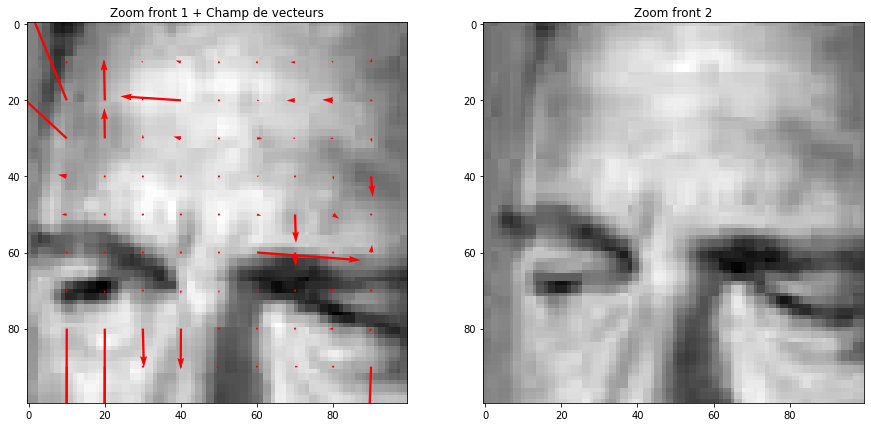

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.001
Lambda =  1
Epsillon =  0.01


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Final Norm Grad :  491.2164538931793


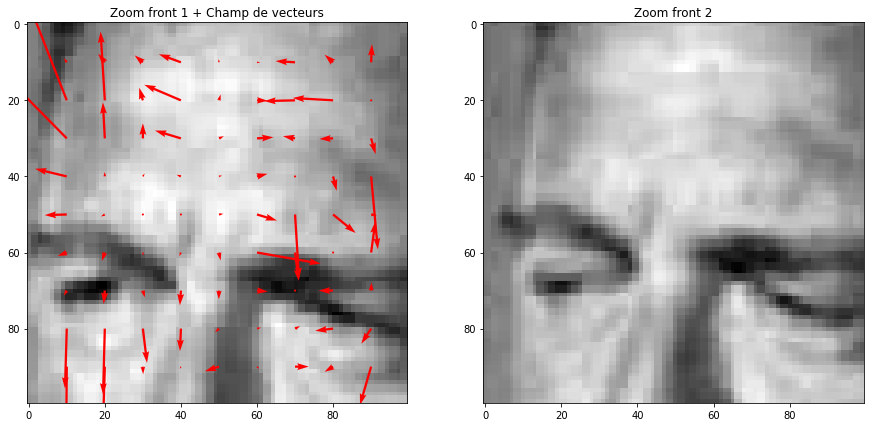

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.1
Lambda =  0.1
Epsillon =  0.01


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Final Norm Grad :  164.87732806364113


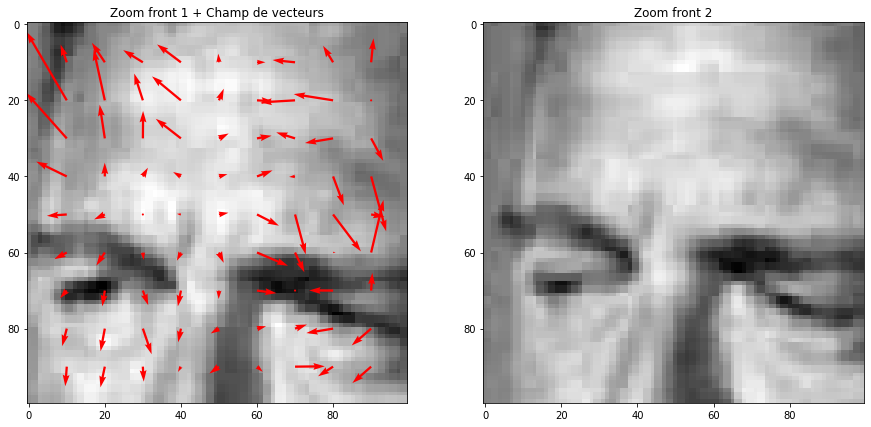

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.1
Lambda =  1
Epsillon =  0.01


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Final Norm Grad :  368.3316067323742


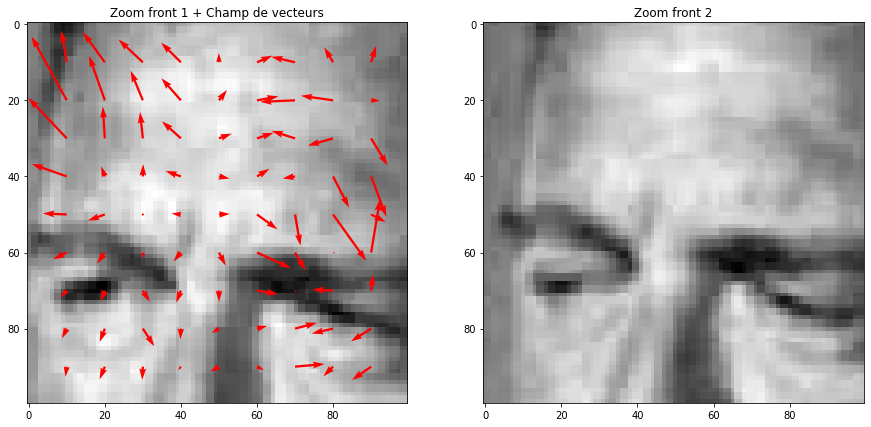

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.001
Lambda =  0.1
Epsillon =  1


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Final Norm Grad :  190.14567927711187


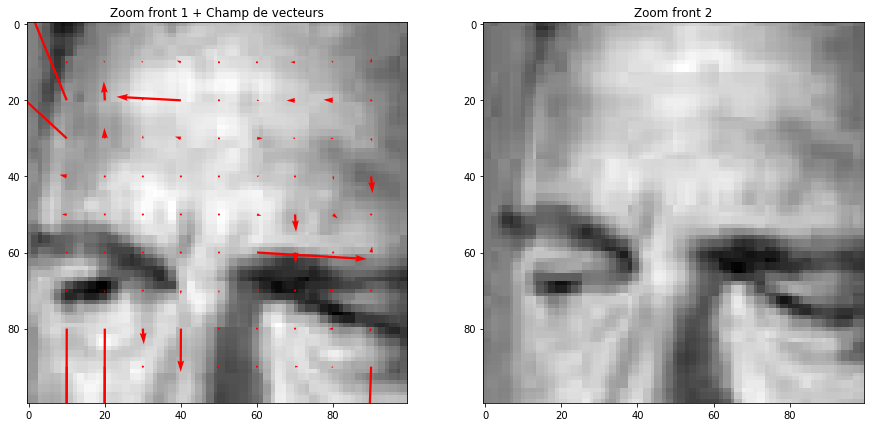

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.001
Lambda =  1
Epsillon =  1


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Final Norm Grad :  183.2378899655059


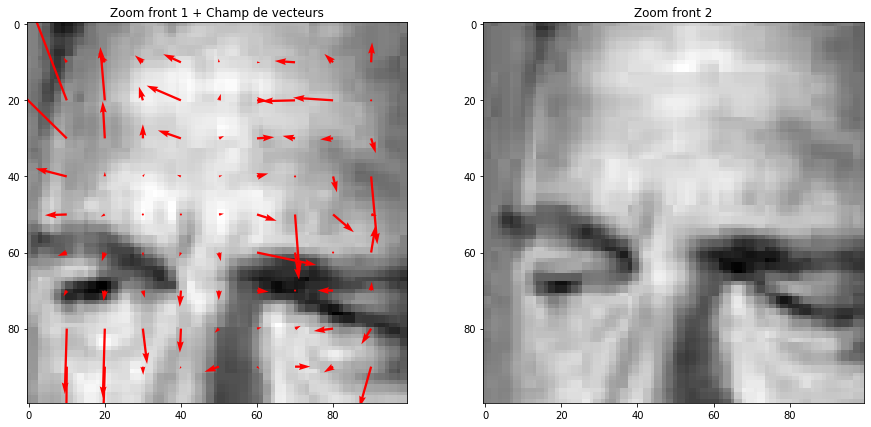

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.1
Lambda =  0.1
Epsillon =  1


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Final Norm Grad :  69.3800636715701


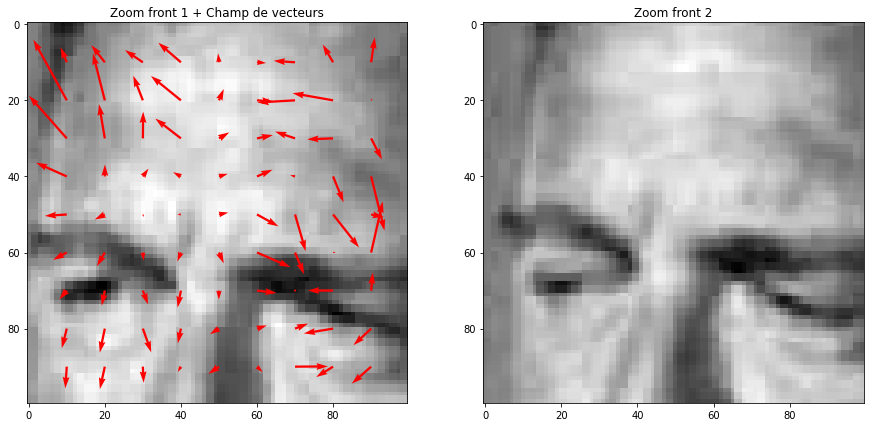

N/A% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 
Pas =  0.1
Lambda =  1
Epsillon =  1


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Final Norm Grad :  96.18003664410584


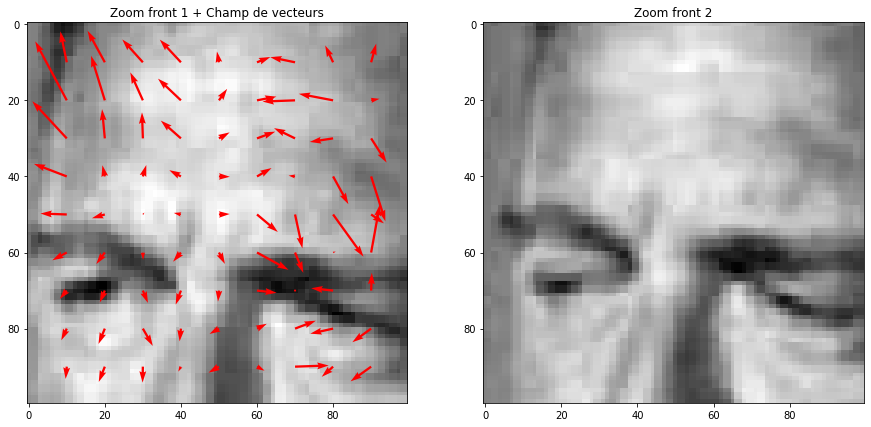

In [ ]:
La=[0.1,1]
Ep=[0.01,1]
Pa=[0.001,0.1]

img1 = 255 * mpimg.imread("image1.png")
img2 = 255 * mpimg.imread("image2.png")

v1 = rgb2gray(img1)[75:175, 140:240]
v2 = rgb2gray(img2)[75:175, 140:240]

for e in range (2):
  for p in range (2):
    for i in range (2):
      print(" ")
      print("Pas = ",Pa[p])
      print("Lambda = ",La[i])
      print("Epsillon = ",Ep[e])
      t1 = Minimize(v1, v2, Lambda = La[i], eps = Ep[e], nbIter = 10, pas = Pa[p])
      field, coord = VectorField(t1, int(np.sqrt(len(v1[0]))))
      plt.figure(figsize=(15,15))
      plt.subplot(1,2,1)
      plt.imshow(v1, cmap='gray')
      plt.quiver(coord[0], coord[1], field[0], field[1], color='r', units='dots', angles='xy', scale_units='xy', lw=3)
      plt.title("Zoom front 1 + Champ de vecteurs")
      plt.subplot(1,2,2)
      plt.imshow(v2, cmap='gray')
      plt.title("Zoom front 2")
      plt.show()

Nous choissisons pour la suite d'utiliser les paramètres suivants : $\lambda = 0.1 , \epsilon = 0.01$ et $pas = 0.1 $ qui nous semble cohérant au niveau du champ de vecteur et de la norme du gradient finale au bout de 10 itérations avec le pas constant.

Image 1 : Zoom front
-------------

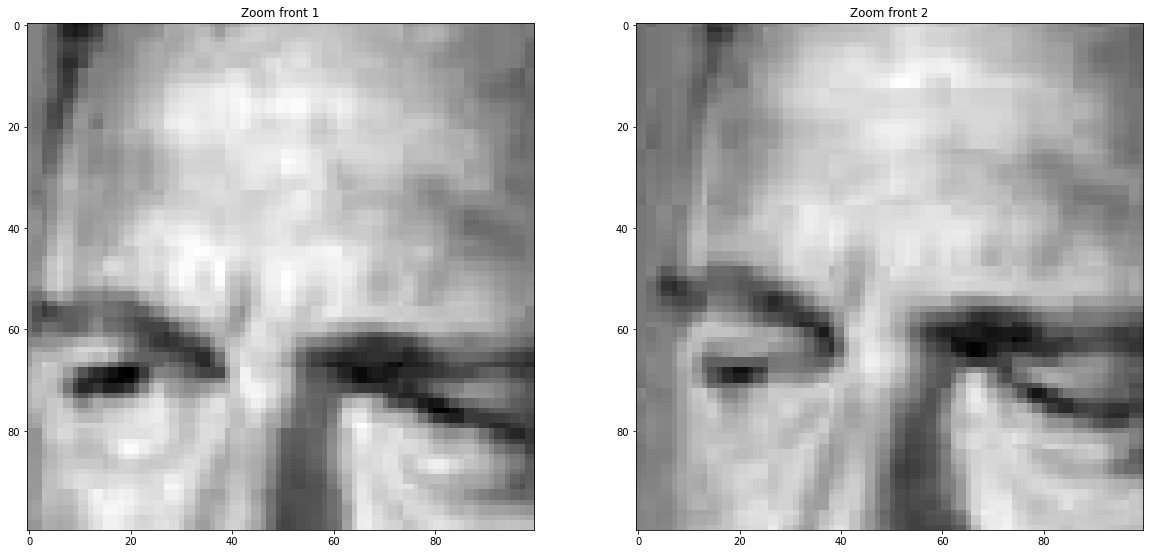

In [ ]:
img1 = 255 * mpimg.imread("image1.png")
img2 = 255 * mpimg.imread("image2.png")

v1 = rgb2gray(img1)[75:175, 140:240]
v2 = rgb2gray(img2)[75:175, 140:240]


plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(v1,cmap='gray')
plt.title("Zoom front 1")
plt.subplot(1,2,2)
plt.imshow(v2,cmap='gray')
plt.title("Zoom front 2")
plt.show()

Test avec le pas optimal :

In [ ]:
t1 = Minimize(v1, v2, Lambda = 0.1, eps = 0.01, nbIter = 10, pas = 0.1, pasopt=True)

100% (10 of 10) |########################| Elapsed Time: 0:00:52 Time:  0:00:52


Final Norm Grad :  211.84065404577416


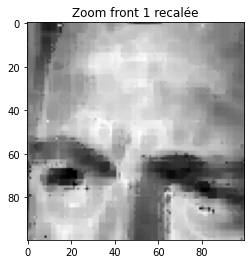

In [ ]:
new_img = GetNewImg(v1,t1)

plt.imshow(new_img, cmap='gray')
plt.title("Zoom front 1 recalée")
plt.show()

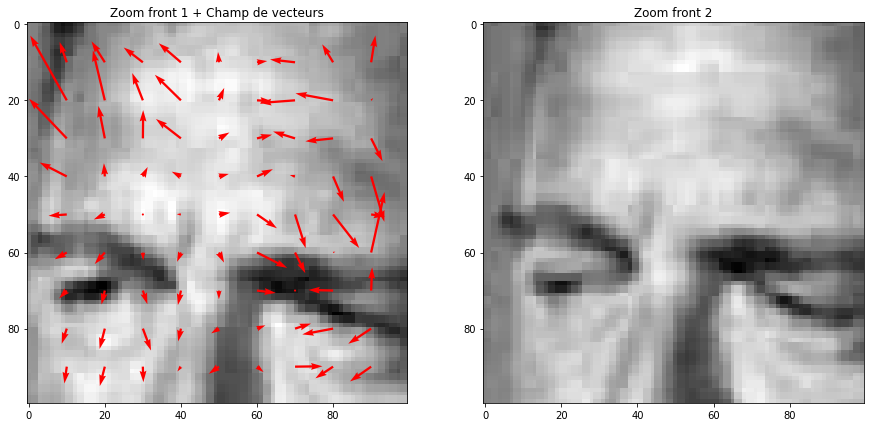

In [ ]:
field, coord = VectorField(t1, int(np.sqrt(len(v1[0]))))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(v1, cmap='gray')
plt.quiver(coord[0], coord[1], field[0], field[1], color='r', units='dots', angles='xy', scale_units='xy', lw=3)
plt.title("Zoom front 1 + Champ de vecteurs")
plt.subplot(1,2,2)
plt.imshow(v2, cmap='gray')
plt.title("Zoom front 2")
plt.show()

100% (50 of 50) |########################| Elapsed Time: 0:04:07 Time:  0:04:07


Final Norm Grad :  15.150660101742771


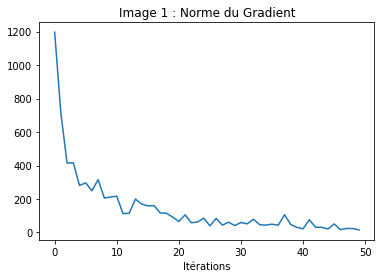

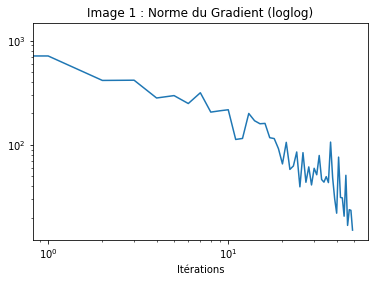

In [ ]:
t1, ng1 = Minimize(v1, v2, Lambda = 0.1, eps = 0.01, nbIter = 50, pas = 0.1, pasopt=True,getNG=True)
plt.plot(ng1)
plt.title('Image 1 : Norme du Gradient')
plt.xlabel('Itérations')
plt.savefig('NGImg1.png')
plt.figure()
plt.plot(ng1)
plt.xscale('log')
plt.yscale('log')
plt.title('Image 1 : Norme du Gradient (loglog)')
plt.xlabel('Itérations')
plt.savefig('NGLImg1.png')

Test avec le pas constant :

In [ ]:
t1 = Minimize(v1, v2, Lambda = 0.1, eps = 0.01, nbIter = 10, pas = 0.1)

100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Final Norm Grad :  493.24973101955953


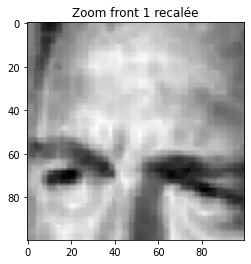

In [ ]:
new_img = GetNewImg(v1,t1)

plt.imshow(new_img, cmap='gray')
plt.title("Zoom front 1 recalée")
plt.show()

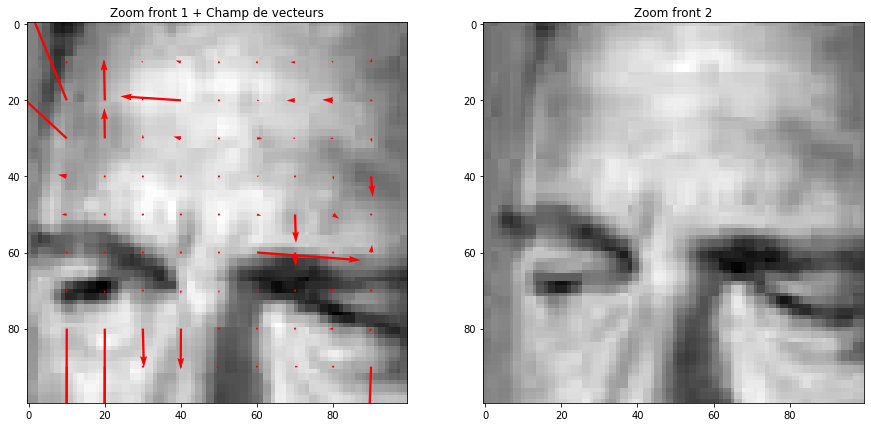

In [ ]:
field, coord = VectorField(t1, int(np.sqrt(len(v1[0]))))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(v1, cmap='gray')
plt.quiver(coord[0], coord[1], field[0], field[1], color='r', units='dots', angles='xy', scale_units='xy', lw=3)
plt.title("Zoom front 1 + Champ de vecteurs")
plt.subplot(1,2,2)
plt.imshow(v2, cmap='gray')
plt.title("Zoom front 2")
plt.show()

100% (50 of 50) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Final Norm Grad :  34.746604025305416


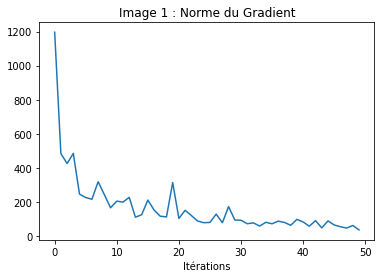

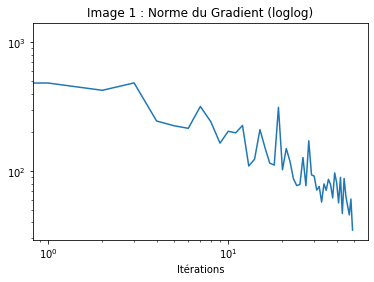

In [ ]:
t1,ng1 = Minimize(v1, v2, Lambda = 0.1, eps = 0.01, nbIter = 50, pas = 0.1, pasopt=False,getNG=True)
plt.plot(ng1)
plt.title('Image 1 : Norme du Gradient')
plt.xlabel('Itérations')
plt.savefig('NGImg1.png')
plt.figure()
plt.plot(ng1)
plt.xscale('log')
plt.yscale('log')
plt.title('Image 1 : Norme du Gradient (loglog)')
plt.xlabel('Itérations')
plt.savefig('NGLImg1.png')

Le résultat est moins bon avec le pas constant, la norme du gradient descent moins vite et le champ de vecteur n'est pas assez représentatif.
Pour la suite nous n'utiliserons que le pas optimal.

Image 2 :Visage
-----

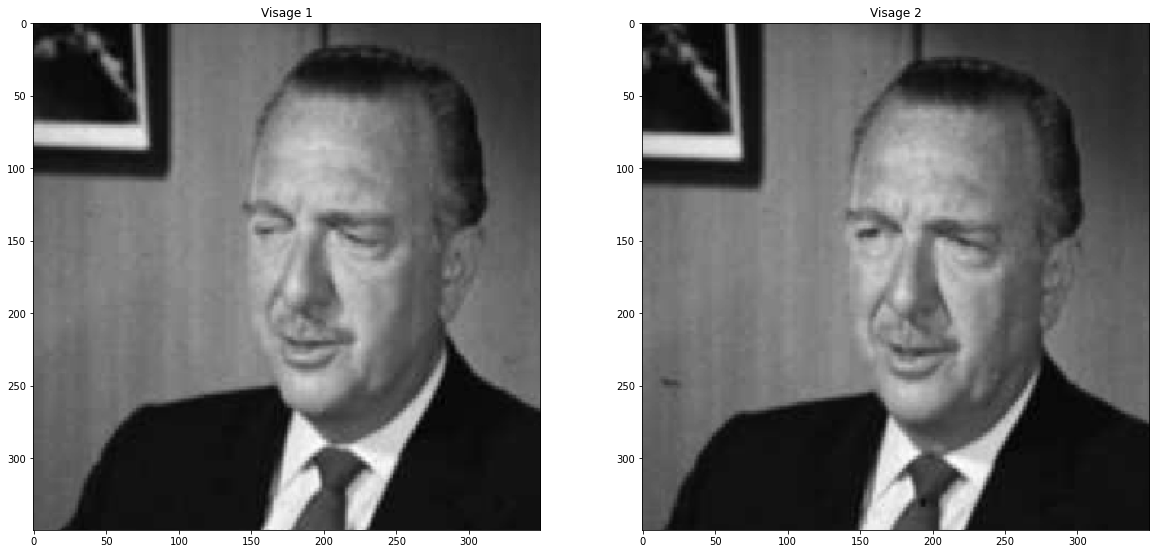

In [ ]:
img1 = 255 * mpimg.imread("image1.png")
img2 = 255 * mpimg.imread("image2.png")

v1 = rgb2gray(img1)
v2 = rgb2gray(img2)[:350,:350]


plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(v2,cmap='gray')
plt.title("Visage 1")
plt.subplot(1,2,2)
plt.imshow(v1,cmap='gray')
plt.title("Visage 2")
plt.show()

In [ ]:
t = Minimize(v1, v2, Lambda = 0.1, eps = 0.01, nbIter = 10, pas = 0.1, pasopt=True)

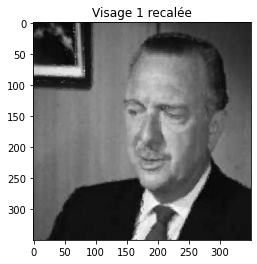

In [ ]:
new_img = GetNewImg(v2,t)

plt.imshow(new_img, cmap='gray')
plt.title("Visage 1 recalée")
plt.show()

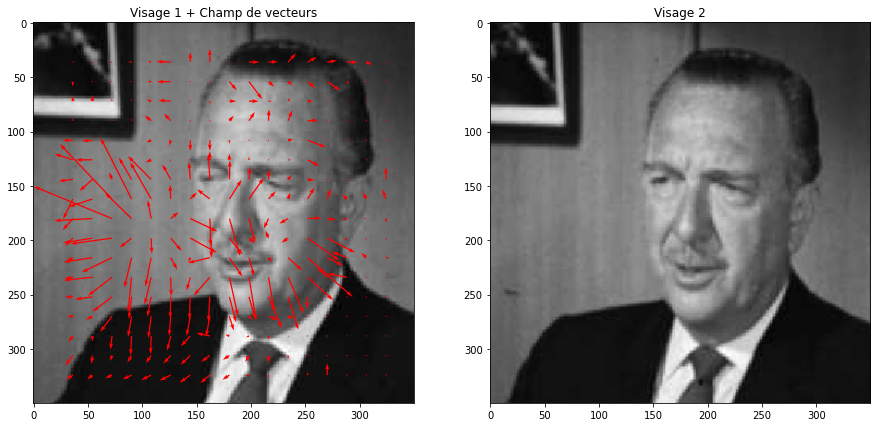

In [ ]:
field, coord = VectorField(t, int(np.sqrt(len(v1[0]))))
sx,sy= v1.shape

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(v2, cmap='gray')
plt.quiver(coord[0], coord[1], field[0], field[1], color='r', units='dots', angles='xy', scale_units='xy', lw=3)
plt.title("Visage 1 + Champ de vecteurs")
plt.subplot(1,2,2)
plt.imshow(v1, cmap='gray')
plt.title("Visage 2")
plt.show()

Image 3 : Toucan
------------

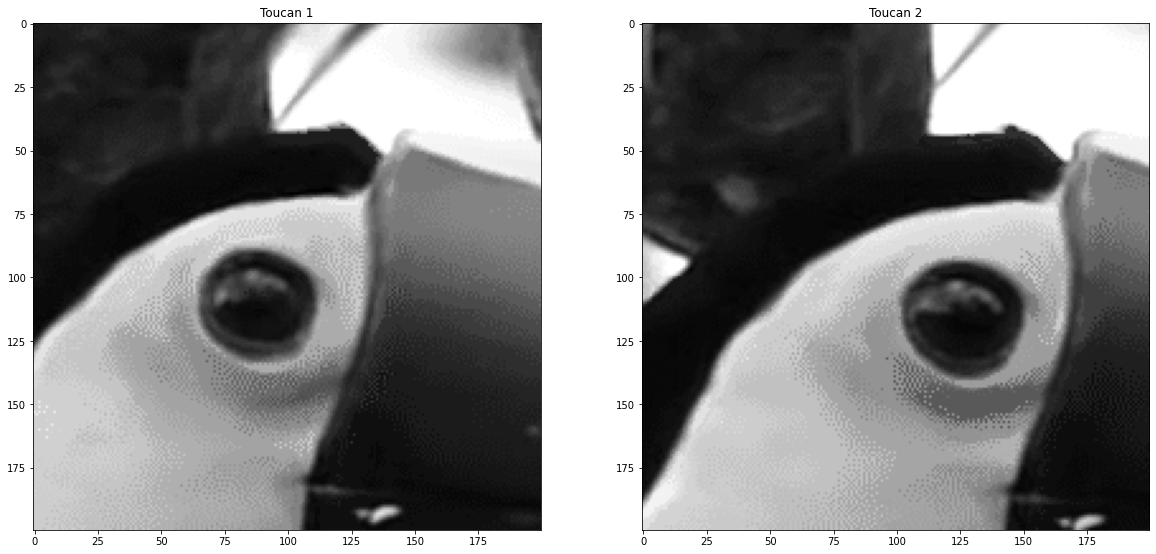

In [ ]:
img1 = 255 * mpimg.imread("Toucan1.png")
img2 = 255 * mpimg.imread("Toucan2.png")

v1 = (0.299*img2[:,:,0] + 0.587*img2[:,:,1] + 0.114*img2[:,:,2]).astype('int')[220:420,980:1180]
v2 = (0.299*img1[:,:,0] + 0.587*img1[:,:,1] + 0.114*img1[:,:,2]).astype('int')[220:420,1020:1220]


#v1 = (0.299*img1[:,:,0] + 0.587*img1[:,:,1] + 0.114*img1[:,:,2]).astype('int')[200:210,750:760] # Images 10 x 10 pour tester
#v2 = (0.299*img2[:,:,0] + 0.587*img2[:,:,1] + 0.114*img2[:,:,2]).astype('int')[200:210,750:760]

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(v1,cmap='gray')
plt.title("Toucan 1")
plt.subplot(1,2,2)
plt.imshow(v2,cmap='gray')
plt.title("Toucan 2")
plt.show()

In [ ]:
t3 = Minimize(v1, v2, Lambda = 0.1, eps = 0.01, nbIter = 10, pas = 0.1, pasopt=True)

100% (10 of 10) |########################| Elapsed Time: 0:03:25 Time:  0:03:25


Final Norm Grad :  428.45492583716293


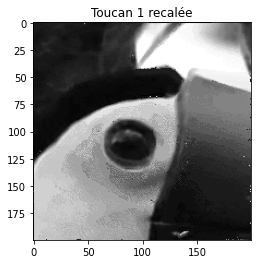

In [ ]:
new_img = GetNewImg(v1,t3)

plt.imshow(new_img, cmap='gray')
plt.title("Toucan 1 recalée")
plt.show()

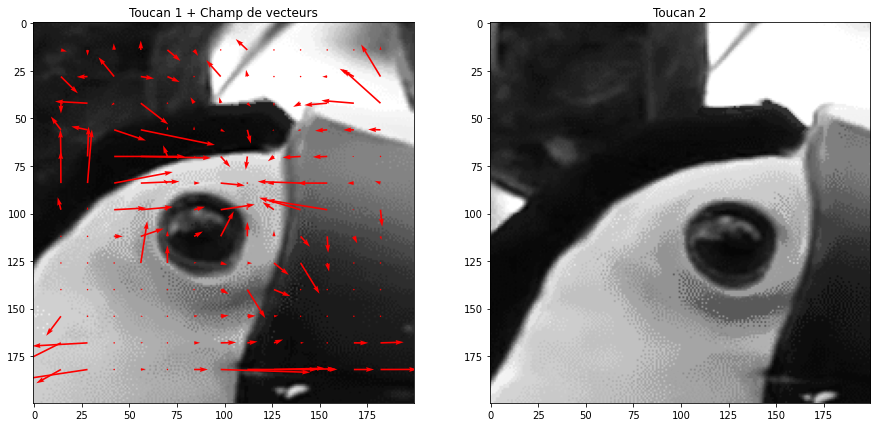

In [ ]:
field, coord = VectorField(t3, int(np.sqrt(len(v1[0]))))
sx,sy= v1.shape

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(v1, cmap='gray')
plt.quiver(coord[0], coord[1], field[0], field[1], color='r', units='dots', angles='xy', scale_units='xy', lw=3)
plt.title("Toucan 1 + Champ de vecteurs")
plt.subplot(1,2,2)
plt.imshow(v2, cmap='gray')
plt.title("Toucan 2")
plt.show()

Image 4 : Moto
----------

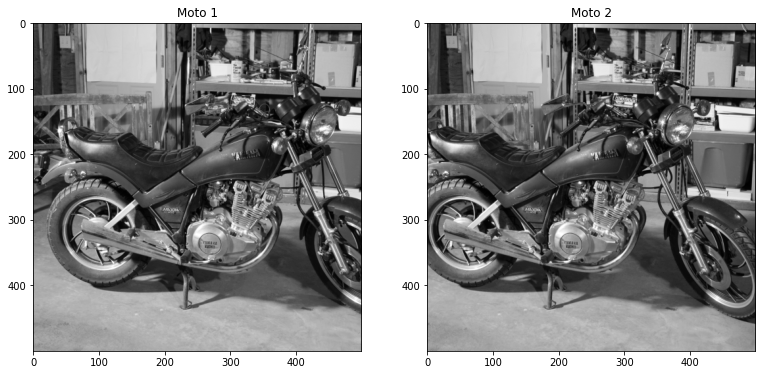

In [ ]:
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.registration import optical_flow_ilk
reference_image, moving_image, disp = stereo_motorcycle()

# --- Convert the images to gray level: color is not supported.
reference_image = rgb2gray(reference_image)[0:500,100:600]
moving_image = rgb2gray(moving_image)[0:500,100:600]

plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(reference_image,cmap='gray')
plt.title("Moto 1")
plt.subplot(1,3,2)
plt.imshow(moving_image,cmap='gray')
plt.title("Moto 2")
plt.show()

In [ ]:
t4 = Minimize(reference_image, moving_image, Lambda = 0.1, eps = 0.01, nbIter = 10, pas = 0.1, pasopt=True)

100% (10 of 10) |########################| Elapsed Time: 0:12:30 Time:  0:12:30


Final Norm Grad :  288.24686989395065


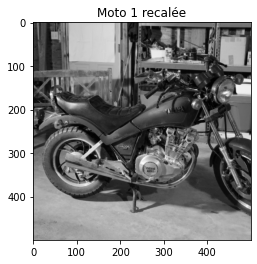

In [ ]:
new_img = GetNewImg(reference_image,t4)

plt.imshow(new_img, cmap='gray')
plt.title("Moto 1 recalée")
plt.show()

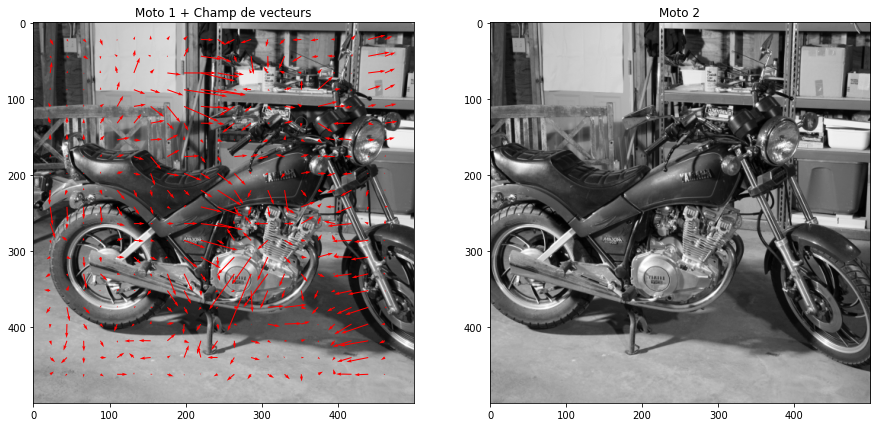

In [ ]:
field, coord = VectorField(t4, int(np.sqrt(len(reference_image[0]))))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(reference_image, cmap='gray')
plt.quiver(coord[0], coord[1], field[0], field[1], color='r', units='dots', angles='xy', scale_units='xy', lw=3)
plt.title("Moto 1 + Champ de vecteurs")
plt.subplot(1,2,2)
plt.imshow(moving_image, cmap='gray')
plt.title("Moto 2")
plt.show()